### Using pre-trained model

Today we're going to build and fine-tune CNN based on weights pre-trained on ImageNet: the largest image classification dataset as of now.
More about imagenet: http://image-net.org/
Setup: classify from a set of 1000 classes.

In [38]:
import requests

# class labels
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
labels = {int(key):value for (key, value) in requests.get(LABELS_URL).json().items()}

In [22]:
print(list(labels.items())[:5])

[(0, 'tench, Tinca tinca'), (1, 'goldfish, Carassius auratus'), (2, 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias'), (3, 'tiger shark, Galeocerdo cuvieri'), (4, 'hammerhead, hammerhead shark')]


### TorchVision
PyTorch has several companion libraries, one of them being [torchvision](https://github.com/pytorch/vision/tree/master/) - it contains a number of popular vision datasets, preprocessing tools and most importantly, [pre-trained models](https://github.com/pytorch/vision/tree/master/torchvision/models).

For now, we're going to use torch Inception-v3 module.

We're gonna use the inception-v3 network:
![img](https://hackathonprojects.files.wordpress.com/2016/09/googlenet_diagram.png?w=650&h=192)

Let's first look at the code here: [url](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py)

In [17]:
from torchvision.models.inception import inception_v3

model = inception_v3(pretrained=True,      # load existing weights
                     transform_input=True, # preprocess input image the same way as in training
                    )

model.aux_logits = False # don't predict intermediate logits (yellow layers at the bottom)
model.train(False)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d (3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d (32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d (64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d (80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True)
  )
  (Mixed_5b): InceptionA(
    (branch1x1): BasicConv2d(
      (conv): Conv2d (192, 64, kernel_si

In [18]:
import torch
from torch.autograd import Variable

dummy_x = Variable(torch.randn(5, 3, 299, 299))
model(dummy_x)

Variable containing:
-1.5628  0.9915  1.3647  ...  -1.7494 -0.6447  1.8850
-1.5029  0.8341  1.7832  ...  -2.0479 -0.5539  2.0465
-1.2008  1.0779  1.9003  ...  -1.7224 -0.3872  1.5797
-1.0230  1.2093  2.0440  ...  -2.0166 -0.4014  1.6763
-1.1667  1.1877  2.1214  ...  -1.7635 -0.4708  1.4964
[torch.FloatTensor of size 5x1000]

### Predict class probabilities

/home/jheuristic/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/jheuristic/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


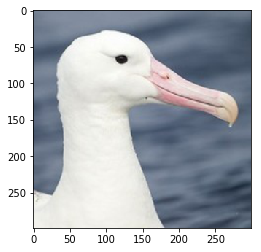

top-10 classes are: 
 [prob : class label]
0.9747 :	albatross
0.0026 :	turnstile
0.0005 :	Shetland sheepdog
0.0005 :	llama
0.0004 :	collie
0.0003 :	hammerhead
0.0003 :	drake
0.0003 :	nipple
0.0003 :	Polaroid camera


In [41]:
import matplotlib.pyplot as plt
from scipy.misc import imresize
%matplotlib inline

img = imresize(plt.imread('sample_images/albatross.jpg'), (299,299)) / 255.
plt.imshow(img)
plt.show()

img = Variable(torch.FloatTensor(img.reshape([1, 299, 299, 3]).transpose([0,3,1,2])))

probs = torch.nn.functional.softmax(model(img), dim=-1)

probs = probs.data.numpy()

top_ix = probs.ravel().argsort()[-1:-10:-1]
print ('top-10 classes are: \n [prob : class label]')
for l in top_ix:
    print ('%.4f :\t%s' % (probs.ravel()[l], labels[l].split(',')[0]))



### Having fun with pre-trained nets

In [35]:
!wget http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg -O img.jpg

--2018-01-27 17:27:15--  http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg
Resolving cdn.com.do (cdn.com.do)... 2400:cb00:2048:1::6819:9076, 2400:cb00:2048:1::6819:8f76, 104.25.143.118, ...
Connecting to cdn.com.do (cdn.com.do)|2400:cb00:2048:1::6819:9076|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51048 (50K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  49,85K   316KB/s    in 0,2s    

2018-01-27 17:27:15 (316 KB/s) - ‘img.jpg’ saved [51048/51048]



/home/jheuristic/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/jheuristic/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


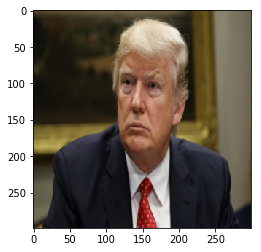

top-10 classes are: 
 [prob : class label]
0.7468 :	suit
0.0806 :	Windsor tie
0.0379 :	groom
0.0042 :	Loafer
0.0035 :	oboe
0.0030 :	academic gown
0.0022 :	wig
0.0020 :	bow tie
0.0019 :	Sussex spaniel


In [42]:
img = imresize(plt.imread('img.jpg'), (299,299)) / 255.
plt.imshow(img)
plt.show()

img = Variable(torch.FloatTensor(img.reshape([1, 299, 299, 3]).transpose([0,3,1,2])))

probs = torch.nn.functional.softmax(model(img), dim=-1)

probs = probs.data.numpy()

top_ix = probs.ravel().argsort()[-1:-10:-1]
print ('top-10 classes are: \n [prob : class label]')
for l in top_ix:
    print ('%.4f :\t%s' % (probs.ravel()[l], labels[l].split(',')[0]))



# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [ ]:
!wget https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1 -O data.zip
!unzip data.zip

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [ ]:
#extract features from images
from tqdm import tqdm
from scipy.misc import imresize
import os
X = []
Y = []

#this may be a tedious process. If so, store the results in some pickle and re-use them.
for fname in tqdm(os.listdir('train/')):
    y = fname.startswith("cat")
    img = imread("train/"+fname)
    img = imresize(img,(IMAGE_W,IMAGE_W))
    img = zoo.inception_v3.preprocess_input(img[None].astype('float32'))
    
    features = <use network to process the image into features>
    # Hint: use model.features(x)
    
    Y.append(y)
    X.append(features)

In [ ]:

X = np.concatenate(X) #stack all [1xfeatures] matrices into one. 
assert X.ndim==2
#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
Y = Y[:len(X)]

In [ ]:
<split data here or use cross-validation>

__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [ ]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Main quest

* Get the score improved!
* You have to reach __at least 95%__ on the test set. More = better.

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.


### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k

### Choose which vgg layers are you going to use
  * Anything but for prob is okay
  * Do not forget that vgg16 uses dropout

### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output

### Train the newly added layers for some iterations
  * you can selectively train some weights by sending the correct parameters in the optimizer
      * `opt = torch.optim.Adam([head_only.parameters()])``
  * it's cruicial to monitor the network performance at this and following steps

### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate
 
### Grading
* 95% accuracy on test yields 10 points
* -1 point per 5% less accuracy

### Some ways to get bonus points
* explore other networks from the model zoo
* play with architecture
* 96%/97%/98%/99%/99.5% test score (screen pls).
* data augmentation, prediction-time data augmentation
* use any more advanced fine-tuning technique you know/read anywhere
* ml hacks that benefit the final score


In [ ]:
#<A whole lot of your code>